In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Data preprocessing

In [2]:
df = pd.read_csv('./embeddings_combined.csv')
df = df[df['sector'] != 'Banks'] # There is one outlier that has 'banks' as sector label for some reason
df = df[df['country'] == 'US'] # uncomment if you want to only analyze US companies

In [3]:
from sklearn.preprocessing import StandardScaler

embedding_cols = [str(i) for i in range(1024)]
scaler = StandardScaler()
df[embedding_cols] = scaler.fit_transform(df[embedding_cols].values)

In [4]:
# Dimensionality Reeduction using PCA
from sklearn.decomposition import PCA

PCA_reducer = PCA(n_components=512)
pca_embeddings = PCA_reducer.fit_transform(df[embedding_cols])

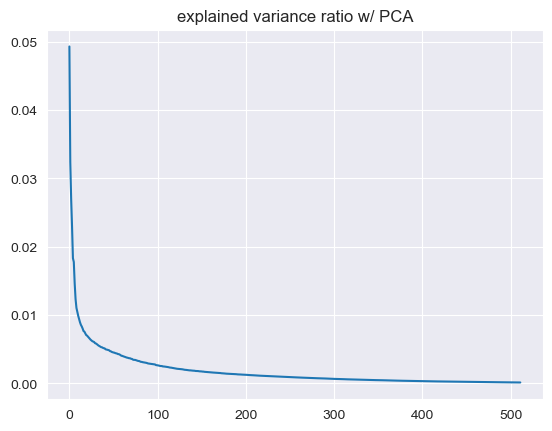

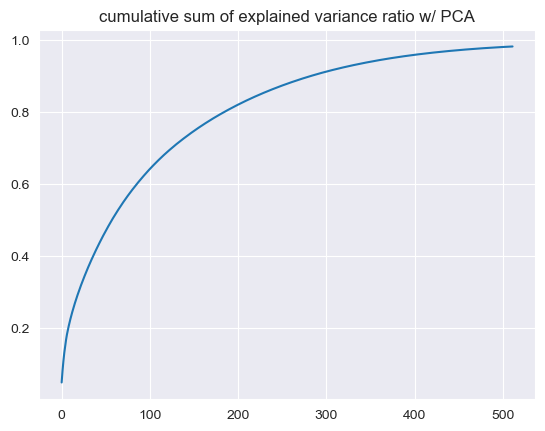

In [5]:
var_ratio = PCA_reducer.explained_variance_ratio_
plt.plot(var_ratio)
plt.title("explained variance ratio w/ PCA")
plt.show()
plt.plot(np.cumsum(var_ratio))
plt.title("cumulative sum of explained variance ratio w/ PCA")
plt.show()

In [6]:
evectors = PCA_reducer.components_ # (component, eigenvector)

In [7]:
def vector_search(db: np.ndarray, query: np.ndarray):
    # Calculate the dot product between db and query vectors
    dot_product = np.dot(query, db.T)

    # Compute the norm of each vector in the database
    db_norm = np.linalg.norm(db, axis=1)

    # Compute the norm of each query vector
    query_norm = np.linalg.norm(query, axis=1)

    # To avoid division by zero, add a small constant in the norm calculation
    db_norm[db_norm == 0] = 1e-10
    query_norm[query_norm == 0] = 1e-10

    # Calculate the cosine similarity by normalizing the dot product with the norms
    cosine_similarity = dot_product / np.outer(query_norm, db_norm)

    return cosine_similarity

In [8]:
search_result = vector_search(df[embedding_cols].values, evectors)
# negative so that we can make it descending
# find the top three
ranked_values = -np.sort(-search_result, axis=1)[:, :5]
ranked_indices = np.argsort(-search_result, axis=1)[:, :5]

In [9]:
eigencompanies = []
for i, (indices, values) in enumerate(zip(ranked_indices, var_ratio)):
    top_companies = df.iloc[indices]
    top_companies = top_companies[['companyName', 'sector', 'industry']]

    # Calculating majority vote and agreement for 'sector'
    most_common_sector = top_companies['sector'].mode()[0]
    sector_agreement = (top_companies['sector'] == most_common_sector).mean()

    # Calculating majority vote and agreement for 'industry'
    most_common_industry = top_companies['industry'].mode()[0]
    industry_agreement = (top_companies['industry'] == most_common_industry).mean()

    subset = {
        "PCA": i+1,
        "variance_explained": values,
        "names": top_companies['companyName'].to_list(),
        "sector": most_common_sector,
        "sector_agreement": sector_agreement,
        "industry": most_common_industry,
        "industry_agreement": industry_agreement
    }
    eigencompanies.append(subset)

# Concatenate all results into a single DataFrame
eigencompanies = pd.DataFrame.from_dict(eigencompanies)

In [17]:
eigencompanies[['PCA', 'variance_explained', 'names', 'sector', 'industry']]

,PCA,variance_explained,names,sector,industry
0,1,0.049313,"[Reliant Bancorp, Inc., Old National Bancorp, ...",Financial Services,Banks—Regional
1,2,0.032399,"[United Energy Corp., Mountain Energy Inc, U.S...",Energy,Oil & Gas E&P
2,3,0.026996,"[Biotech Acquisition Company, Deep Medicine Ac...",Financial Services,Shell Companies
3,4,0.022965,"[Granite Falls Energy, LLC, Central Natural Re...",Energy,Oil & Gas Refining & Marketing
4,5,0.018319,"[Ralph Lauren Corporation, Bath & Body Works, ...",Consumer Cyclical,Apparel Manufacturing
...,...,...,...,...,...
507,508,0.000127,"[Activision Blizzard Inc, Ladenburg Thalmann F...",Financial Services,Capital Markets
508,509,0.000126,"[Epic Corp., Beacon Redevelopment Industrial C...",Financial Services,Conglomerates
509,510,0.000123,"[Wrap Technologies, Inc., Good Vibrations Shoe...",Consumer Cyclical,Asset Management
510,511,0.000122,"[GeneLink, Inc., Western Metals Corporation, B...",Energy,Oil & Gas Refining & Marketing


#### Conclusion: The first principal component only reduces the variance by 3.7%. However, we can bring the dimensions down to 512 with 98% of variance intact. Considering that the curse of dimensionality is exponentially increasing problem, cutting it down to half is pretty remarkable when it comes to applying semantic searches. Also, looking at the top 5 companies and their sectors, the eigenvectors seem to have some consistent semantic meanings. We can take advantage of this information to label each PCA dimension and perhaps make it more explainable.

## Clustering

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [12]:
label_encoder = LabelEncoder()
df['sector_encoded'] = label_encoder.fit_transform(df['sector']) # change sector to industry if you want to do the analysis on the industry labels.
num_classes = len(df['sector'].unique())
unique_labels = df['sector_encoded'].unique()
X = df[embedding_cols].values
y = labels_true = df['sector_encoded'].values

C:\Users\Siwoo\AppData\Local\Temp\ipykernel_14604\472216813.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sector_encoded'] = label_encoder.fit_transform(df['sector']) # change sector to industry if you want to do the analysis on the industry labels.


calculates inertia created by existing sector label vs k-means clustering

In [13]:
kmeans = KMeans(n_clusters=num_classes, n_init='auto')
labels_predicted = kmeans.fit_predict(X)

centroids_natural = np.array([X[labels_true == label].mean(axis=0) for label in unique_labels])
inertia_natural = sum(np.min([np.sum((X - centroid)**2, axis=1) for centroid in centroids_natural], axis=0))


inertia_kmeans = kmeans.inertia_
print("Inertia for natural labels:", inertia_natural)
print("Inertia for k-means:", inertia_kmeans)

Inertia for natural labels: 8112746.7248122655
Inertia for k-means: 7801213.029338856


In [14]:
silhouette_natural = silhouette_score(X, y)
silhouette_kmeans = silhouette_score(X, labels_predicted)

print("Silhouette Score for natural labels:", silhouette_natural)
print("Silhouette Score for k-means:", silhouette_kmeans)

Silhouette Score for natural labels: 0.020766361280926033
Silhouette Score for k-means: 0.042629427860144606


### Conclusion: k-means clustering seems to find clustering schemes that outperform human labels in the semantic space measured by inertia and Silhouette score

### Experiment 3: visualization of linear separability between sector classes

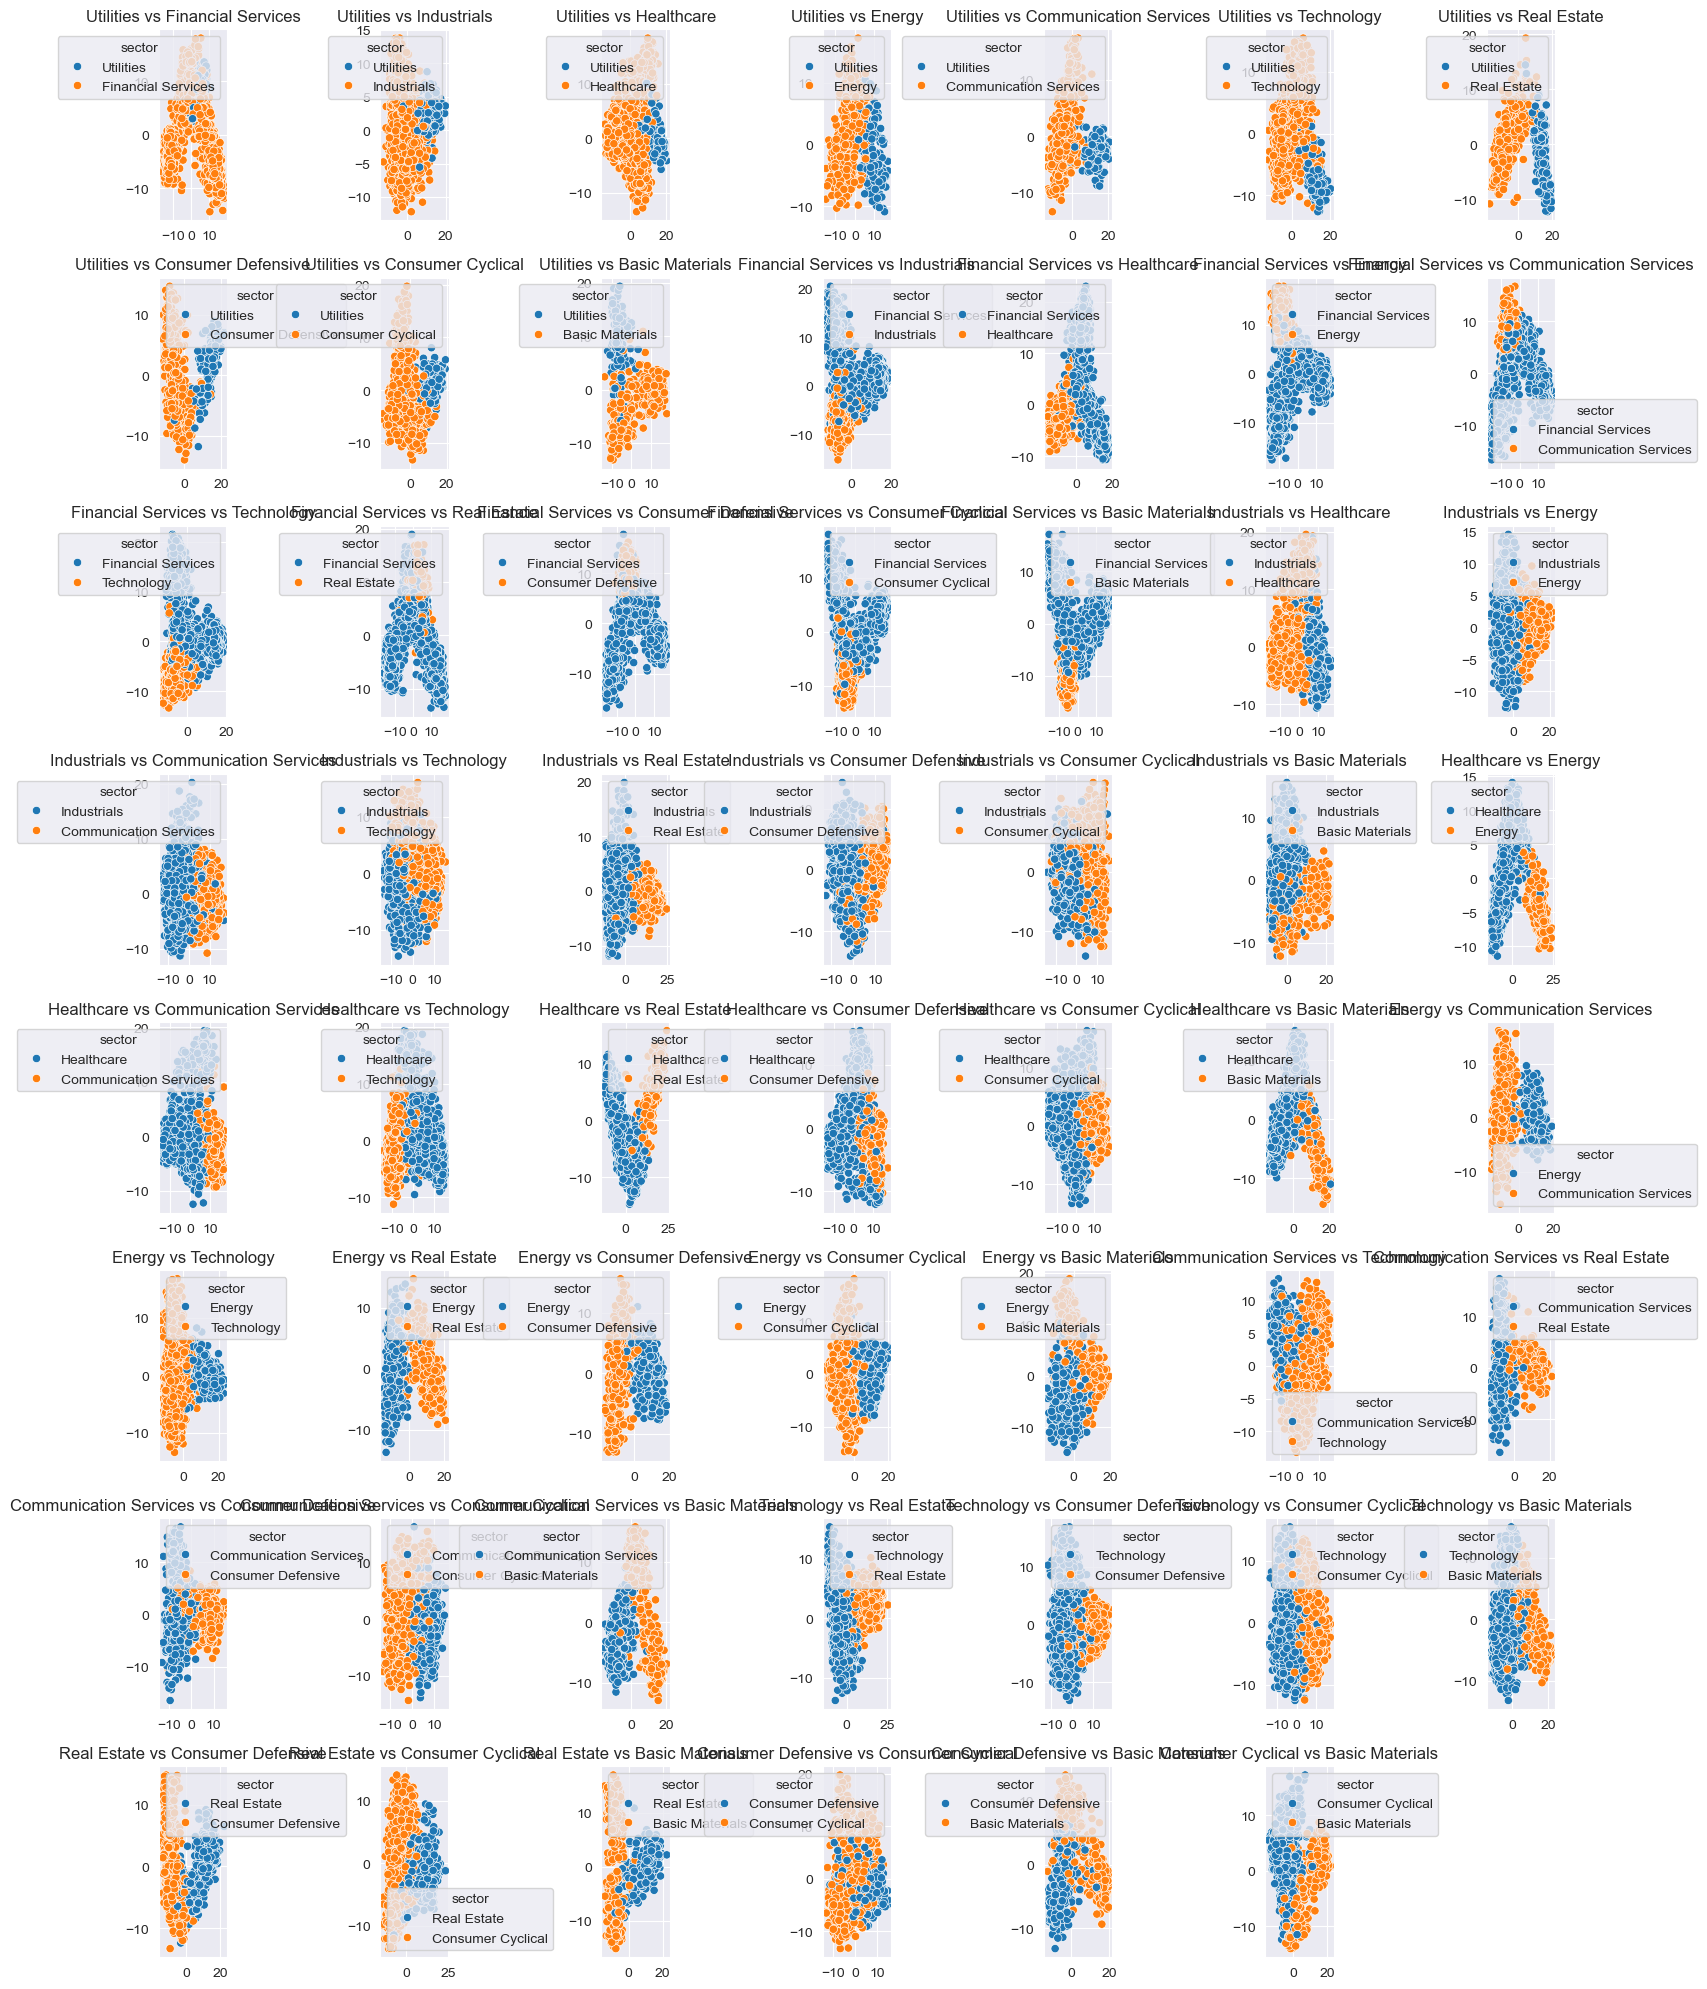

In [15]:
import seaborn as sns
from itertools import combinations

# Number of unique sectors
unique_sectors = df['sector'].unique()
# Prepare the figure grid
fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(15, 20))
axes = axes.flatten()

# Iterate over all unique pairs of sectors
for i, (sec1, sec2) in enumerate(combinations(unique_sectors, 2)):
    if i >= 64:
        break  # We only have space for 12 plots (4x3 grid)
    # Filter data for the two specific sectors
    df_1vs2 = df.loc[df['sector'].isin([sec1, sec2]), embedding_cols + ['sector']]
    y_1vs2 = df_1vs2['sector']
    # PCA transformation
    pca = PCA(n_components=2)
    df_1vs2_embed = pca.fit_transform(df_1vs2[embedding_cols])
    # Scatter plot on the subplot axes
    ax = axes[i]
    sns.scatterplot(x=df_1vs2_embed[:, 0], y=df_1vs2_embed[:, 1], hue=y_1vs2, ax=ax)
    ax.set_title(f'{sec1} vs {sec2}')

# Hide unused axes if there are fewer than 12 combinations
for j in range(i + 1, 56):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

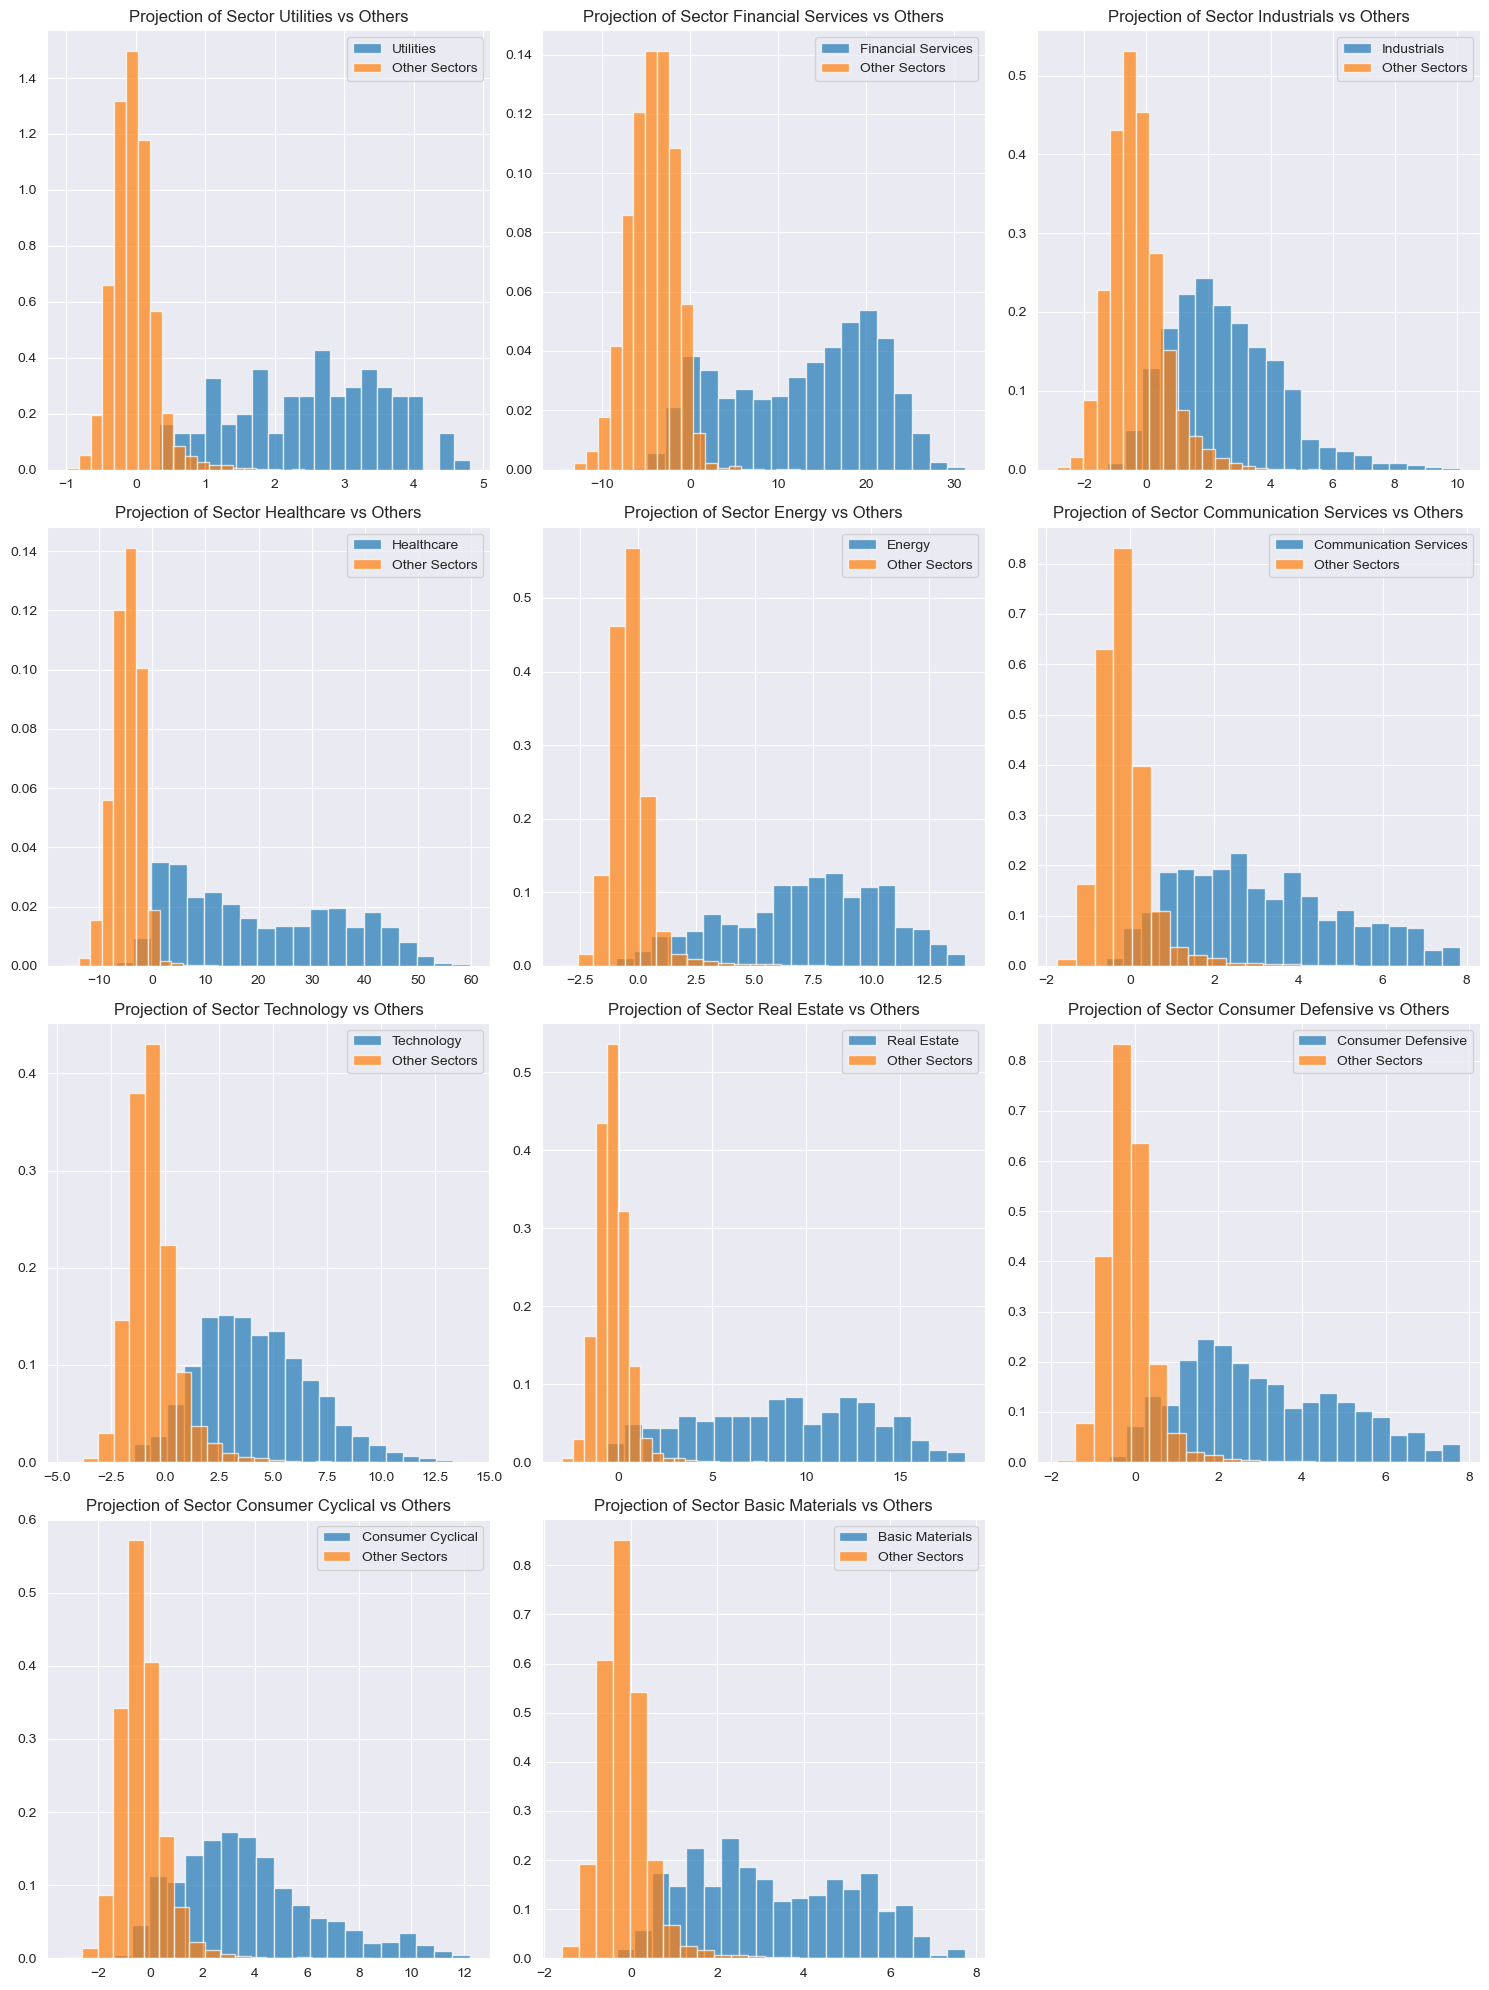

In [16]:
from sklearn.linear_model import LogisticRegression

# Prepare the figure grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))  # Adjust as needed based on the number of sectors
axes = axes.flatten()

# Iterate over each unique sector
for i, sector in enumerate(df['sector'].unique()):
    if i >= 12:
        break  # We only have space for 12 plots (4x3 grid)

    # Create the target array where the current sector is 1 and all others are 0
    y = (df['sector'] == sector).astype(int)

    # Fit logistic regression model
    model = LogisticRegression(fit_intercept=False, max_iter=10000)
    model.fit(df[embedding_cols], y)

    # Project data onto the logistic regression coefficient vector
    projection = np.dot(df[embedding_cols], model.coef_.T).ravel()

    # Plot histogram of projections on the subplot axes
    ax = axes[i]
    # Separate histograms for each class
    ax.hist(projection[y == 1], bins=20, alpha=0.7, label=f'{sector}', density=True)
    ax.hist(projection[y == 0], bins=20, alpha=0.7, label='Other Sectors', density=True)
    ax.set_title(f'Projection of Sector {sector} vs Others')
    ax.legend()

# Hide unused axes if there are fewer than 12 sectors
for j in range(i + 1, 12):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

#### Conclusion: Yeah no wonder why linear models could perform as well as some other nonlinear models like neural networks. They are all linearly separable in the embedding space.

It is also interesting to note that basic materials have two bumps. What could that be?